In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/AutoEncoder")

In [3]:
# imports
from keras.datasets import cifar10
from keras.layers import Conv2D, Flatten, Dense, Reshape
from keras.layers import Conv2DTranspose, Input
from keras.models import Model
import keras.backend as K
import numpy as np
import cv2
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [13]:
"""Dynamic and Hyper parameters"""
image_shape = (32, 32, 3)
image_size = image_shape[0]
channel_num = image_shape[-1]
latent_dim = 256

filters = [64, 128, 256]
stride = 2
kernel_size = 3
padding = "same"
activation = "relu"
initializer = "he_normal"

batch_size = 512
epochs = 10

In [5]:
"""Load and preprocess dataset"""
def rgb2gray(x):

    y = []
    for i in range(x.shape[0]):
        y.append(cv2.cvtColor(x[i], cv2.COLOR_RGB2GRAY))
    return np.asarray(y)


(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train_gray = rgb2gray(x_train).reshape((-1, image_size, image_size, 1))
x_test_gray  = rgb2gray(x_test).reshape((-1 ,image_size, image_size, 1))

"""Encoder configurations"""
def build_encoder(inputs):

    x = inputs
    for filter in filters:
        x = Conv2D(filters=filter,
                   kernel_size=kernel_size,
                   strides=stride,
                   padding=padding,
                   activation=activation,
                   kernel_initializer=initializer)(x)
    conv_shape = K.int_shape(x)
    x = Flatten()(x)
    outputs = Dense(units = latent_dim)(x)

    model = Model(inputs, outputs, name = "Encoder")
    model.summary()
    return model, conv_shape

170500096/170498071 [==============================] - 6s 0us/step


In [6]:
"""Decoder configurations"""
def build_decoder(inputs, denseShape):

    x = inputs
    x = Dense(denseShape[1] * denseShape[2] * denseShape[3])(x)
    x = Reshape(denseShape[1:])(x)
    for filter in filters[::-1]:
        x = Conv2DTranspose(filters=filter,
                   kernel_size=kernel_size,
                   strides=stride,
                   padding=padding,
                   activation=activation,
                   kernel_initializer=initializer)(x)
    outputs = Conv2DTranspose(filters=channel_num,
                        kernel_size=1,
                        padding=padding,
                        strides=1,
                        activation="sigmoid")(x)
    model = Model(inputs, outputs, name = "Decoder")
    model.summary()
    return model

In [16]:
"""Plot"""
def plot(autoEnc):

    rows = 10
    cols = 10
    color_imgs = x_train[:rows * cols]
    gray_imgs = x_train_gray[:rows * cols]

    plt.figure(1, figsize=(16, 8))
    plt.axis("off")
    color = np.vstack([np.hstack(row) for row in np.split(color_imgs, rows, axis=0)])
    plt.subplot(1, 2, 1)
    plt.imshow(color)
    plt.imsave("color.png", color)
    plt.subplot(1, 2, 2)
    gray = np.vstack([np.hstack(row) for row in np.split(gray_imgs, rows, axis=0)])
    plt.imshow(gray.reshape(*(gray.shape[:-1])), cmap="gray")
    plt.imsave("gray.png", gray.reshape(*(gray.shape[:-1])))

    gray_test = x_test_gray[:rows * cols]
    rgb_predicted = autoEnc.predict(x_test_gray)[:rows * cols]

    plt.figure(2, figsize=(16, 8))
    plt.axis("off")
    gray = np.vstack([np.hstack(row) for row in np.split(gray_test, rows, axis=0)])
    plt.subplot(1, 2, 1)
    plt.imshow(gray.reshape(*(gray.shape[:-1])), cmap="gray")
    plt.imsave("gray2.png", gray.reshape(*(gray.shape[:-1])))

    rgb = np.vstack([np.hstack(row) for row in np.split(rgb_predicted, rows, axis=0)])
    plt.subplot(1, 2, 2)
    plt.imshow(rgb)
    plt.imsave("rgb.png", rgb)
    plt.show()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

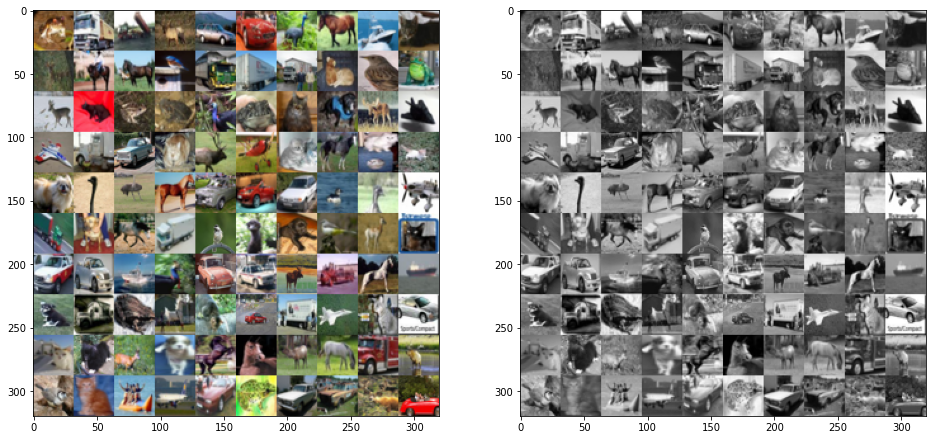

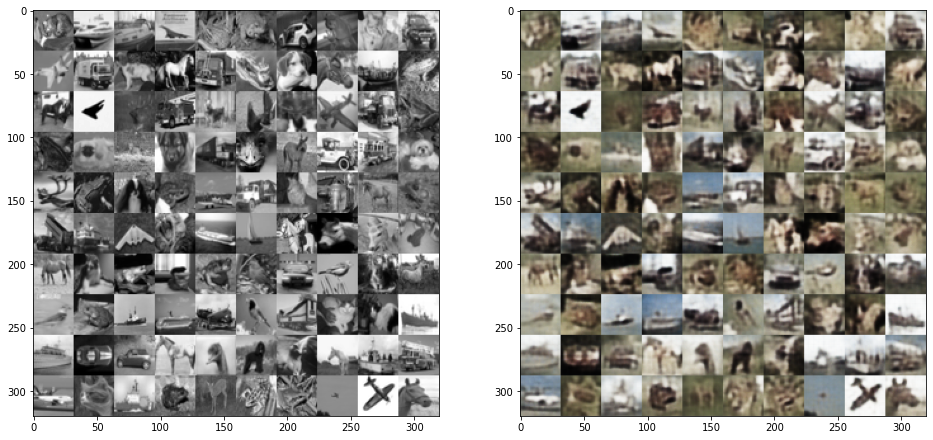

In [17]:
enc_inputs = Input(shape = (*image_shape[:-1], 1))
enc, denseShape = build_encoder(enc_inputs)

dec_inputs = Input(shape = (latent_dim,))
dec = build_decoder(dec_inputs, denseShape)

autoEnc_inputs = enc_inputs
autoEnc_outputs = dec(enc(autoEnc_inputs))
autoEnc = Model(autoEnc_inputs, autoEnc_outputs, name = "Auto Encoder")
autoEnc.summary()
autoEnc.compile(loss = "mse", optimizer = "adam")
autoEnc.fit(x_train_gray,
            x_train,
            batch_size = batch_size,
            epochs=epochs,
            validation_data = [x_test_gray, x_test])
plot(autoEnc)